# PRÁCTICAS DE REDES NEURONALES ARTIFICIALES (TSCAO): Parte III



## 4. REDES NEURONALES DE FUNCIÓN BASE RADIAL

**Código para implementar una Red Neuronal RBF**

Vamos a implementar la función base radial:

In [1]:
import numpy as np

# Se ha añadido el np.linalg.norm para calcular la distancia euclidea
# entre la observación y el centro del cluster. Es necesario hacer esto
# para poder trabajar con datos multidimensionales. Usar una resta no es
# suficiente.

def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * np.linalg.norm(x-c)**2)

Ahora necesitaremos usar el algoritmo de agrupación k-means para determinar los centros de los cluster. El siguiente código nos da los centros de clúster y las desviaciones estándar de los clústeres.

In [2]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
       Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    #clusters = np.random.choice(np.squeeze(X), size=k)
    indices_aleatorios = np.random.randint(0,len(X),size=k)
    clusters = X[indices_aleatorios]
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

Este código implementa el algoritmo de clustering k-means y calcula las desviaciones estándar. Si hay un cluster con ninguno o uno de los puntos asignados, simplemente promediamos la desviación estándar de los otros grupos. (No podemos calcular la desviación estándar sin puntos de datos, y la desviación estándar de un solo punto de datos es 0).

Ahora implementaremos la clase RBF:

In [3]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True, verbose = False):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.verbose = verbose
 
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
                
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2).all() for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
 
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
 
                loss = (y[i] - F).flatten() ** 2
                if self.verbose:
                    print('Loss: {0:.2f}'.format(loss[0]))
 
                # backward pass
                error = -(y[i] - F).flatten()
 
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
            
                
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(np.mean(F))
        return np.array(y_pred)


Ahora pasamos a implementar el algoritmo genético y la red RBF pero entrenandola con geneticos:

In [4]:
import math
from sklearn.metrics import mean_squared_error

class Individuo(object):
    def __init__(self, k=2, rbf=rbf, inferStds = True, rand_factor_scale = 5):
        self.k = k
        self.rbf = rbf
        self.w = np.random.randn(k)*rand_factor_scale
        self.b = np.random.randn(1)*rand_factor_scale
        self.inferStds = inferStds
        self.fitness = math.inf
        self.centers = None
        self.stds = None

    def predict(self, X):

        if self.centers is None:
            if self.inferStds:
                # compute stds from data
                self.centers, self.stds = kmeans(X, self.k)
            else:
                # use a fixed std
                self.centers, _ = kmeans(X, self.k)
                dMax = max([np.abs(c1 - c2).all() for c1 in self.centers for c2 in self.centers])
                self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)
    
    def evaluate(self, X, y):
        predicciones = self.predict(X)
        
        self.fitness = mean_squared_error(y, predicciones)

In [5]:
import copy
import random

class GeneticRBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, rbf=rbf, tam_poblacion=50, inferStds=True, verbose = False):
        self.individuo = Individuo(k, rbf, inferStds)
        self.verbose = verbose
        self.tam_poblacion = tam_poblacion
    
    
    def predict(self, X):
        return self.individuo.predict(X)
    
    def __inicializar_poblacion(self):
        # generamos un vector con tam_poblacion filas (cada fila un individuo)
        # y cada individuo de tamaño tam_individuos
        
        poblacion = []
        
        for i in range(self.tam_poblacion):
            # creamos la poblacion como copias del individuo que ya tenemos
            poblacion.append(Individuo(self.individuo.k, self.individuo.rbf, self.individuo.inferStds))

        return poblacion
    
    def __evaluar_poblacion(self, poblacion, X, y):
        # simplemente evaluamos cada individuo
        for individuo in poblacion:
            individuo.evaluate(X, y)
            
        return poblacion
    
    def __cruce_blx_alpha(self, valor1, valor2, alpha = 0.5):
        punto_padre = valor1
        punto_madre = valor2 
        
        # si el punto de cruce del padre es mayor que el de la madre, los intercambiamos
        if punto_padre > punto_madre:
            punto_padre, punto_madre = punto_madre, punto_padre

        seccion = punto_madre - punto_padre

        punto_padre = punto_padre - seccion * alpha
        punto_madre = punto_madre + seccion * alpha

        punto_padre = max(0.0, punto_padre)
        punto_madre = max(0.0, punto_madre)

        valor_hijo1 = punto_padre + random.random() * (punto_madre - punto_padre)
        valor_hijo2 = punto_padre + random.random() * (punto_madre - punto_padre)
        
        return valor_hijo1, valor_hijo2
    
    def __cruce_blx_alpha_global(self, padre, madre, alpha = 0.5):
        nuevo_w_hijo1 = []
        nuevo_w_hijo2 = []
        
        hijo1 = copy.deepcopy(padre)
        hijo2 = copy.deepcopy(madre)

        
        for i in range(len(padre.w)):
            
            valor_hijo1, valor_hijo2 = self.__cruce_blx_alpha(padre.w[i], madre.w[i], alpha)
            
            nuevo_w_hijo1.append(valor_hijo1)
            nuevo_w_hijo2.append(valor_hijo2)
            
        hijo1.w = np.array(nuevo_w_hijo1)
        hijo2.w = np.array(nuevo_w_hijo2)
        
    
        hijo1.b, hijo2.b = self.__cruce_blx_alpha(padre.b, madre.b, alpha)

        return hijo1, hijo2

    def __seleccionar_poblacion(self,poblacion):

        nueva_poblacion = []

        for elemento in range(len(poblacion)):
            primero = random.randint(0,len(poblacion)-1)
            segundo = random.randint(0,len(poblacion)-1)

            while primero == segundo:
                segundo = random.randint(0,len(poblacion)-1)

            if poblacion[primero].fitness > poblacion[segundo].fitness:
                nueva_poblacion.append(poblacion[segundo])
            else:
                nueva_poblacion.append(poblacion[primero])

        return nueva_poblacion
    
    def __cruzar_poblacion(self, poblacion, probabilidad_cruce):
        
        poblacion_cruzada = []
        
        for i in range(0, len(poblacion), 2):
            # miramos si estos dos se cruzan
            if random.random() < probabilidad_cruce:
                nuevo_hijo1, nuevo_hijo2 = self.__cruce_blx_alpha_global(poblacion[i], poblacion[i + 1])
            else:
                nuevo_hijo1, nuevo_hijo2 = poblacion[i], poblacion[i + 1]
                
            poblacion_cruzada.append(nuevo_hijo1)
            poblacion_cruzada.append(nuevo_hijo2)
    
        return poblacion_cruzada


    def __mutar(self, individuo, lim_inf=0.5, lim_sup=1.5):

        hijo = copy.deepcopy(individuo)

        gen_a_mutar = random.randint(0,len(individuo.w))

        if (random.random() < 0.5):

            if gen_a_mutar == len(individuo.w):
                porcentaje = random.uniform(lim_inf, lim_sup)

                seccion_inferior = individuo.b - individuo.b*porcentaje
                seccion_superior = individuo.b + individuo.b*porcentaje

                hijo.b = random.uniform(seccion_inferior, seccion_superior)
            else:
                porcentaje = random.uniform(lim_inf, lim_sup)
                seccion_inferior = individuo.w[gen_a_mutar] - individuo.w[gen_a_mutar]*porcentaje
                seccion_superior = individuo.w[gen_a_mutar] + individuo.w[gen_a_mutar]*porcentaje

                hijo.w[gen_a_mutar] = random.uniform(seccion_inferior, seccion_superior)
        else:
            if gen_a_mutar == len(individuo.w):
                hijo.b = np.random.randn(1)*5
            else:
                hijo.w[gen_a_mutar] = np.random.randn(1)*5

        return hijo

    def __mutar_poblacion(self, poblacion, probabilidad_mutacion):
        poblacion_mutada = []
        for i in range(len(poblacion)):
            # miramos si estos dos se cruzan
            if random.random() < probabilidad_mutacion:
                mutado = self.__mutar(poblacion[i])
            else:
                mutado = poblacion[i]

            poblacion_mutada.append(mutado)

        return poblacion_mutada
    
    def __algoritmo_genetico_reales(self, X, y, num_iteraciones = 1000, probabilidad_cruce = 0.75, probabilidad_mutacion = 0.05, epsilon=0.01, porcentaje_elitismo=0.05, iteraciones_cataclismo=15, umbral_cataclismos = 3):
        poblacion = self.__inicializar_poblacion()

        poblacion = self.__evaluar_poblacion(poblacion, X, y)

        iteracion_actual = 1

        iteraciones_sin_mejorar = 0
        cataclismos = 0
        parar = False
        while (iteracion_actual < num_iteraciones and self.individuo.fitness > epsilon and not parar):

            # selección de la poblacion
            poblacion_seleccionada = self.__seleccionar_poblacion(poblacion)

            # cruce de la poblacion
            nueva_poblacion = self.__cruzar_poblacion(poblacion_seleccionada, probabilidad_cruce)

            # mutación de la población
            nueva_poblacion = self.__mutar_poblacion(nueva_poblacion, probabilidad_mutacion)

            # reemplazamiento de la poblacion
            poblacion = nueva_poblacion
            
            poblacion = self.__evaluar_poblacion(poblacion, X, y)

            hay_mejora = False
            for individuo in poblacion:
                if individuo.fitness < self.individuo.fitness:
                    # lo hacemos con copia profunda
                    self.individuo = copy.deepcopy(individuo)
                    iteraciones_sin_mejorar = 0
                    cataclismos = 0
                    hay_mejora = True

                    if (self.verbose):
                        print(self.individuo.fitness)
            iteracion_actual += 1

            if not hay_mejora:
                iteraciones_sin_mejorar += 1

            # Elitismo + Cataclismo
            if (iteraciones_sin_mejorar >= iteraciones_cataclismo):

                cataclismos += 1

                if self.verbose:
                    print("\nCataclismo\n")

                mejores = copy.deepcopy(poblacion)
                mejores.sort(key=lambda a: a.fitness, reverse=True)
                mejores = mejores[:int(len(mejores)*porcentaje_elitismo)]

                # Queremos mutar todos los genes, no solo uno.
                for i in range(len(self.individuo.w)+1):
                    poblacion = self.__mutar_poblacion(poblacion, 0.9)

                poblacion[:len(mejores)] = mejores

                poblacion = self.__evaluar_poblacion(poblacion, X, y)

                iteraciones_sin_mejorar = 0

            if (cataclismos >= umbral_cataclismos):
                parar = True

            if self.verbose and iteracion_actual % 100 == 0:
                print("Iteración actual: ", iteracion_actual)
    
    
    def fit(self, X, y, iteraciones = 100, epsilon=0.01,
            porcentaje_elitismo = 0.05, iteraciones_cataclismo=15, umbral_cataclismos=3):
        # tenemos que aprender un vector de tamaño w y el valor de b
        self.__algoritmo_genetico_reales(X, y, num_iteraciones=iteraciones,
                                         epsilon=epsilon,
                                         porcentaje_elitismo=porcentaje_elitismo,
                                         iteraciones_cataclismo = iteraciones_cataclismo,
                                         umbral_cataclismos= umbral_cataclismos)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

rbfnet = GeneticRBFNet(verbose=True)
rbfnet.fit(X, y, iteraciones=100)

y_pred = rbfnet.predict(X)

8.22749852440183
3.0394318564129366
2.207564710290354
0.9347854340888188
0.925725518562353
0.8206235985080055
0.6258053489437213
0.5610928542019277
0.5282617008124593
0.47250364915071835
0.4253607448467233
0.3662781356875219
0.32190510572424214
0.3042126415491403
0.2860314064837197
0.28391321791572016
0.27650432832211097
0.26106737378699785
0.2564284362762095
0.2532850497627297
0.24912661177546291
0.24887504458880147
0.24873072371600125
0.2483843672604758
0.24782755402132242
0.24543991552719546
0.24510933898275428
0.24509988700349072
0.08288268837263643

Cataclismo

0.04137872663242298

Cataclismo


Cataclismo


Cataclismo



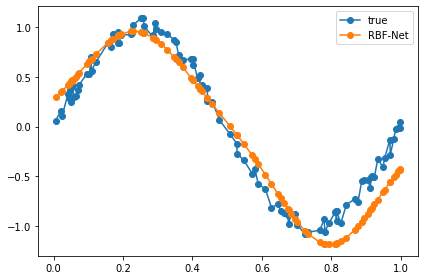

0.04137872663242298


In [7]:
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

print(mean_squared_error(y,y_pred))

In [8]:
# Cargamos los nuevos datos

import pandas as pd

training = pd.read_csv("../datos/preprocesados/training_horas.csv")
test = pd.read_csv("../datos/preprocesados/test_horas.csv")

x_train = training.to_numpy()[:,:-1]
y_train = training.to_numpy()[:,-1]

x_test = test.to_numpy()[:,:-1]
y_test = test.to_numpy()[:,-1]

In [9]:
rbfnet = GeneticRBFNet(verbose=True)
rbfnet.fit(x_train, y_train)

y_pred = rbfnet.predict(x_test)
print(mean_squared_error(y_pred, y_test))

689.7299491064393
445.2574837230725
413.6645763053903
274.5064949619266
262.03402330838935
240.187870107083
175.6863369350915
125.93148668680927
70.65942984334012
35.50678953862746
32.14695420874157
11.4305022332315
10.899171009837751
6.228207070830039
6.207869058204786
6.205149211279613
6.203733216731748
6.203403323923691
6.20335042359125
6.203331559029991
6.2033313402054375
6.2033308684088935
6.203324767770782
6.2033116501487715
6.203307325367229
6.203305048351801
6.203300246696892
6.203297894470942
6.203292690067414
6.203291106430797
6.203289045090584
6.203288690682035
6.203288607966526
6.203288127461401
6.203286762583084
6.203286481207989
6.203285887069529
6.203285832650282
6.203285414189084
6.203266151444031
6.203251283812298

Cataclismo


Cataclismo

6.203246250617363
Iteración actual:  100
4.728137990305444


In [10]:
rbfnet = RBFNet(verbose=True)
rbfnet.fit(x_train, y_train)

y_pred = rbfnet.predict(x_test)
print(mean_squared_error(y_pred, y_test))

Loss: 688.00
Loss: 838.13
Loss: 799.62
Loss: 780.20
Loss: 854.31
Loss: 804.44
Loss: 1034.19
Loss: 1124.79
Loss: 1112.30
Loss: 1001.11
Loss: 894.37
Loss: 1015.71
Loss: 1001.33
Loss: 1000.09
Loss: 953.01
Loss: 892.57
Loss: 759.45
Loss: 663.49
Loss: 708.82
Loss: 754.89
Loss: 791.27
Loss: 739.09
Loss: 635.69
Loss: 522.17
Loss: 493.25
Loss: 652.92
Loss: 628.20
Loss: 588.33
Loss: 561.09
Loss: 514.09
Loss: 461.07
Loss: 427.34
Loss: 529.78
Loss: 536.69
Loss: 519.60
Loss: 502.54
Loss: 538.40
Loss: 457.85
Loss: 378.63
Loss: 439.90
Loss: 449.15
Loss: 454.36
Loss: 426.48
Loss: 409.72
Loss: 345.68
Loss: 290.15
Loss: 380.32
Loss: 388.31
Loss: 372.78
Loss: 345.13
Loss: 352.27
Loss: 290.98
Loss: 239.17
Loss: 289.45
Loss: 279.11
Loss: 269.38
Loss: 264.70
Loss: 255.89
Loss: 217.43
Loss: 183.60
Loss: 247.08
Loss: 258.20
Loss: 279.46
Loss: 272.08
Loss: 262.56
Loss: 180.46
Loss: 136.19
Loss: 184.30
Loss: 189.19
Loss: 172.63
Loss: 156.88
Loss: 149.25
Loss: 103.73
Loss: 77.97
Loss: 111.30
Loss: 119.98
Loss: 

In [8]:
# Probamos a hacer varias ejecuciones con diferentes parametros

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import pandas as pd

def custom_grid_search(grid, X_train, y_train, X_test, y_test, resultsData, genetic=False):
    mejor_modelo = None
    mse_mejor_modelo = 0

    # sacamos las combinaciones de hiperparámetros del grid
    sampler = ParameterGrid(grid)

    # recorremos las combinaciones de parámetros
    for params in sampler:

        # ajustamos el modelo y predecimos
        if genetic:
            modelo = GeneticRBFNet(**params)
        else:
            modelo = RBFNet(**params)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # obtenemos la tasa de acierto y el número de reglas obtenidas por el modelo
        mse = mean_squared_error(y_pred, y_test)

        # almacenamos los resultados
        params_list = list(params.values())
        resultsData.loc[len(resultsData)] = [params_list[1], params_list[2], params_list[0], mse]

        # si este modelo es el mejor hasta el momento, lo almacenamos como el mejor
        if mse < mse_mejor_modelo:
            mejor_modelo = modelo
            mse_mejor_modelo = mse

    return mejor_modelo, resultsData

In [9]:
# Grid RBFNet distribución uniforme con ruido

grid = {"k": [2, 4, 6, 8, 10],
        "lr": [0.0001, 0.001, 0.01, 0.1],
        "inferStds": [True, False]}

results = pd.DataFrame({"k": [], "lr": [], "inferStds": [], "mse": []})

mejor_modelo, results = custom_grid_search(grid, X, y, X, y, results,genetic=False)

print(results.sort_values("mse"))

       k      lr  inferStds       mse
39  10.0  0.1000        0.0  0.005929
35   8.0  0.1000        0.0  0.006564
38  10.0  0.0100        0.0  0.008365
33   8.0  0.0010        0.0  0.015474
34   8.0  0.0100        0.0  0.020422
2    2.0  0.0100        1.0  0.028288
1    2.0  0.0010        1.0  0.034129
31   6.0  0.1000        0.0  0.034826
30   6.0  0.0100        0.0  0.036824
14   8.0  0.0100        1.0  0.062359
18  10.0  0.0100        1.0  0.065341
15   8.0  0.1000        1.0  0.066734
10   6.0  0.0100        1.0  0.072526
6    4.0  0.0100        1.0  0.105263
29   6.0  0.0010        0.0  0.106755
19  10.0  0.1000        1.0  0.114364
26   4.0  0.0100        0.0  0.114564
3    2.0  0.1000        1.0  0.146550
37  10.0  0.0010        0.0  0.149061
22   2.0  0.0100        0.0  0.167734
5    4.0  0.0010        1.0  0.167836
25   4.0  0.0010        0.0  0.193267
11   6.0  0.1000        1.0  0.201234
32   8.0  0.0001        0.0  0.216791
13   8.0  0.0010        1.0  0.224096
7    4.0  0.

In [10]:
# Grid GeneticRBFNet distribución uniforme con ruido

gridGenetico = {"k": [2, 4, 6, 8, 10],
        "tam_poblacion": [50, 100, 150],
        "inferStds": [True, False]}

resultsGenetico = pd.DataFrame({"k": [], "tam_poblacion": [], "inferStds": [], "mse": []})

mejor_modelo, resultsGenetico = custom_grid_search(gridGenetico, X, y, X, y, resultsGenetico,genetic=True)
print(resultsGenetico.sort_values("mse"))

       k  tam_poblacion  inferStds       mse
0    2.0           50.0        1.0  0.027181
1    2.0          100.0        1.0  0.032138
2    2.0          150.0        1.0  0.033348
22   6.0          100.0        0.0  0.108686
28  10.0          100.0        0.0  0.123727
25   8.0          100.0        0.0  0.128347
23   6.0          150.0        0.0  0.130933
5    4.0          150.0        1.0  0.131927
21   6.0           50.0        0.0  0.147873
26   8.0          150.0        0.0  0.148463
7    6.0          100.0        1.0  0.151862
8    6.0          150.0        1.0  0.157905
6    6.0           50.0        1.0  0.162304
13  10.0          100.0        1.0  0.168397
4    4.0          100.0        1.0  0.169244
10   8.0          100.0        1.0  0.179459
19   4.0          100.0        0.0  0.179510
11   8.0          150.0        1.0  0.180626
18   4.0           50.0        0.0  0.195017
3    4.0           50.0        1.0  0.195537
14  10.0          150.0        1.0  0.196949
12  10.0  

In [12]:
# Grid RBFNet dataset alumnos

results = pd.DataFrame({"k": [], "lr": [], "inferStds": [], "mse": []})

mejor_modelo, results = custom_grid_search(grid, x_train, y_train, x_test, y_test, results,genetic=False)

print(results.sort_values("mse"))

       k      lr  inferStds       mse
1    2.0  0.0010        1.0  4.364267
21   2.0  0.0010        0.0  4.364277
29   6.0  0.0010        0.0  4.364277
37  10.0  0.0010        0.0  4.364277
25   4.0  0.0010        0.0  4.364277
17  10.0  0.0010        1.0  4.364277
13   8.0  0.0010        1.0  4.364277
33   8.0  0.0010        0.0  4.364277
9    6.0  0.0010        1.0  4.364277
5    4.0  0.0010        1.0  4.364277
6    4.0  0.0100        1.0  4.664447
14   8.0  0.0100        1.0  4.664447
38  10.0  0.0100        0.0  4.664447
18  10.0  0.0100        1.0  4.664447
30   6.0  0.0100        0.0  4.664447
34   8.0  0.0100        0.0  4.664447
22   2.0  0.0100        0.0  4.664447
10   6.0  0.0100        1.0  4.664447
26   4.0  0.0100        0.0  4.664447
2    2.0  0.0100        1.0  4.664451
12   8.0  0.0001        1.0  4.669151
24   4.0  0.0001        0.0  4.669151
16  10.0  0.0001        1.0  4.669151
36  10.0  0.0001        0.0  4.669151
28   6.0  0.0001        0.0  4.669151
8    6.0  0.

In [ ]:
# Grid GeneticRBFNet dataset alumnos

resultsGenetico = pd.DataFrame({"k": [], "tam_poblacion": [], "inferStds": [], "mse": []})

mejor_modelo, resultsGenetico = custom_grid_search(gridGenetico, x_train, y_train, x_test, y_test, resultsGenetico,genetic=True)

In [14]:
print(resultsGenetico.sort_values("mse"))

       k  tam_poblacion  inferStds       mse
1    2.0          100.0        1.0  4.727786
0    2.0           50.0        1.0  4.727815
21   6.0           50.0        0.0  4.728144
10   8.0          100.0        1.0  4.728144
14  10.0          150.0        1.0  4.728144
13  10.0          100.0        1.0  4.728144
22   6.0          100.0        0.0  4.728144
11   8.0          150.0        1.0  4.728144
20   4.0          150.0        0.0  4.728144
7    6.0          100.0        1.0  4.728144
27  10.0           50.0        0.0  4.728144
25   8.0          100.0        0.0  4.728144
29  10.0          150.0        0.0  4.728144
15   2.0           50.0        0.0  4.728144
24   8.0           50.0        0.0  4.728144
16   2.0          100.0        0.0  4.728144
12  10.0           50.0        1.0  4.728144
28  10.0          100.0        0.0  4.728144
19   4.0          100.0        0.0  4.728144
26   8.0          150.0        0.0  4.728144
8    6.0          150.0        1.0  4.728144
17   2.0  